# Some quick postprocessing of MOM6 data to generate SST, MOC, and OHT figures

## Dependencies:
- xarray
- numpy
- cartopy
- matplotlib

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#=================================================
# Modify paths to point to output files
#=================================================
# Case name
case = 'Straight Coast'

# path to ocean_annual file
path_year = '/data2/sragen/MOM6_cases/aquaplanet/MASTERS/straight_coast/run/DATA/300yr/21000101.ocean_annual.nc'
dy = xr.open_dataset(path_year)

# path to ocean_month file
path_month = '/data2/sragen/MOM6_cases/aquaplanet/MASTERS/straight_coast/run/DATA/300yr/21000101.ocean_month.nc'
dm = xr.open_dataset(path_month)

# define some useful variables
lat = dy['yq']
lon = dy['xh']
z = dy['zl']
vmo = dy['vmo']
vhGM = dy['vhGM']
T_ady_2d = dm['T_ady_2d'][-361:-1]
T_diffy_2d = dm['T_diffy_2d'][-361:-1]

#=================================================
# Modify latitudes to point to western and eastern
# boundaries of small basin and northern extent of SO.
# Comment out for AQUA and RIDGE cases. 
#=================================================
x_west = np.where(dy['xh']==211)[0][0]
x_east = np.where(dy['xh']==351)[0][0]
y = np.where(dy['yq']==-35)[0][0]

# Functions used in this notebook

In [6]:
def calculate_OHT(T_ady_2d, T_diffy_2d):
    tady = np.where(np.abs(T_ady_2d) == 1e+20, np.nan, T_ady_2d)
    tady_avg = np.nanmean(tady, axis=0)
    tady_zonal = np.nansum(tady_avg, axis=1)
    tdiffy = np.where(np.abs(T_diffy_2d) == 1e+20, np.nan, T_diffy_2d)
    tdiffy_avg = np.nanmean(tdiffy, axis=0)
    tdiffy_zonal = np.nansum(tdiffy_avg, axis=1)
    OHT = (tady_zonal + tdiffy_zonal)/1e15
    return OHT

def calculate_global_sfn(vmo, vhGM):
    vmo_slice = (np.nanmean(vmo[-31:-1,:,:,:], axis=0))
    vhGM_slice = (np.nanmean(vhGM[-31:-1,:,:,:], axis=0))
    sfn_global_mean = (np.cumsum(np.nansum(vmo_slice/1025, axis=2), axis=0))/(1e6)
    sfn_global_res = (np.cumsum(np.nansum(vhGM_slice/1025, axis=2), axis=0))/(1e6)
    sfn_global_resmean = sfn_global_mean + sfn_global_res
    return sfn_global_mean, sfn_global_res, sfn_global_resmean

def calculate_basin_sfn(vmo, vhGM, x_west, x_east, y):
    vmo_slice = (np.nanmean(vmo[-31:-1,:,:,:], axis=0))
    vhGM_slice = (np.nanmean(vhGM[-31:-1,:,:,:], axis=0))
    sfn_basin_mean = (np.cumsum(np.nansum((vmo_slice[:,y:,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_res = (np.cumsum(np.nansum((vhGM_slice[:,y:,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_resmean = sfn_basin_mean + sfn_basin_res
    return sfn_basin_mean, sfn_basin_res, sfn_basin_resmean

def variablename(*arg):
    names = []
    for i in range(len(arg)):
        item = [tpl[0] for tpl in filter(lambda x: arg[i] is x[1], globals().items())]
        names.append(item)
    str(names).strip('[]')
    return names

# Look at global mean SSTs

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


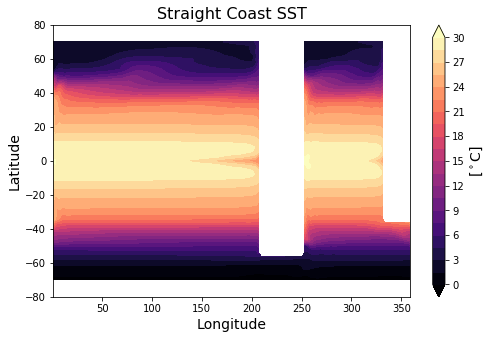

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


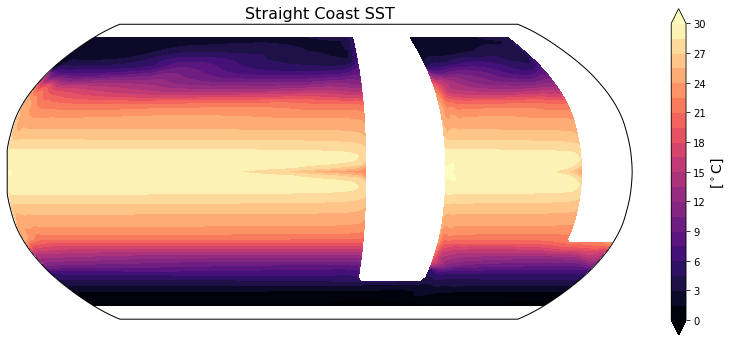

In [7]:
b = np.linspace(0, 30, 21, endpoint=True)
t = np.linspace(0, 30, 11, endpoint=True)
fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(dy['xh'], dy['yh'], np.nanmean(dy['tos'], axis=0), b, cmap='magma', extend='both')
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.ylim(-80,80)
plt.title('{} SST'.format(case), fontsize=16)
#plt.savefig('path/to/image', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy['xh'], dy['yh'], np.nanmean(dy['tos'], axis=0), b, cmap='magma', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} SST'.format(case), fontsize=16)
plt.show()

In [44]:
sfn_mean, sfn_res, sfn_resmean = calculate_global_sfn(vmo, vhGM)
sfn_small_mean, sfn_small_res, sfn_small_resmean = calculate_basin_sfn(vmo, vhGM, x_west, x_east, y)
sfn_large_mean, sfn_large_res, sfn_large_resmean = calculate_basin_sfn(vmo, vhGM, 0, x_west, y)

def plot_sfn(sfn_mean, sfn_res, sfn_resmean, bound):
    t = np.linspace(-bound, bound, 11, endpoint=True)
    b = np.linspace(-bound, bound, 21, endpoint=True)
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    sfn_list = sfn_mean, sfn_res, sfn_resmean
    names = variablename(sfn_mean, sfn_res, sfn_resmean)
    for row in range(3):
        ax = axs[row]
        cf = ax.contourf(lat, z, sfn_list[row], b, cmap='coolwarm', extend='both')
        ax.invert_yaxis() 
        cbar.ax.set_ylabel('[Sv]', fontsize=12)
        plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
        ax.set_title('{}'.format(str(names[row]).strip("['']"))+' '+'{}'.format(case), fontsize=16)
        fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
    plt.show()
    return

plot_sfn(sfn_mean, sfn_res, sfn_resmean, bound)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


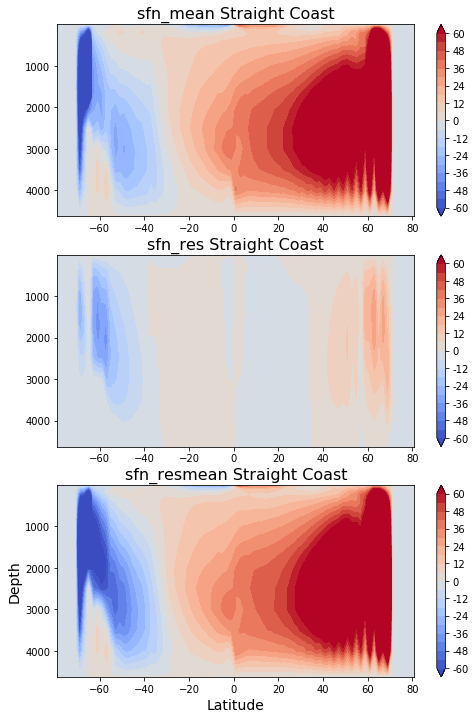

In [45]:

# bound = 60
# t = np.linspace(-bound, bound, 11, endpoint=True)
# b = np.linspace(-bound, bound, 21, endpoint=True)

# fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
# sfn_list = sfn_mean, sfn_res, sfn_resmean
# names = variablename(sfn_mean, sfn_res, sfn_resmean)
# for row in range(3):
#     ax = axs[row]
#     cf = ax.contourf(lat, z, sfn_list[row], b, cmap='coolwarm', extend='both')
#     ax.invert_yaxis() 
#     cbar.ax.set_ylabel('[Sv]', fontsize=12)
#     plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
#     ax.set_title('{}'.format(str(names[row]).strip("['']"))+' '+'{}'.format(case), fontsize=16)
#     fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
# plt.show()

# plt.subplots(figsize=(8,5))
# plt.contourf(lat, z, sfn_mean, t, cmap='coolwarm', extend='both')
# plt.gca().invert_yaxis()
# plt.xlim(-70, 70)
# cbar = plt.colorbar(ticks=t, format = '%.0f')
# cbar.ax.set_ylabel('[Sv]', fontsize=12)
# plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
# plt.title('{} Mean Streamfunction'.format(case), fontsize=16)
# plt.show()

In [5]:
sfn = (vmo/1025).sum('xh').cumsum('zl')

sfn_small = np.cumsum(np.nansum((vmo[:,:,22:,50:100])/1025, axis=3), axis=1)
sfn_small_end = np.nanmean(sfn_small[-20:-10,:,:], axis=0)

large_vmo = np.append(vmo[:,:,22:,100:], vmo[:,:,22:,:50], axis=3)
sfn_large = np.cumsum(np.nansum(large_vmo/1025, axis=3), axis=1)
sfn_large_end = np.nanmean(sfn_large[-20:-10,:,:], axis=0)

sfn_so = np.cumsum(np.nansum((vmo[:,:,:23,:])/1025, axis=3), axis=1)
sfn_so_end = np.nanmean(sfn_so[-20:-10,:,:], axis=0)

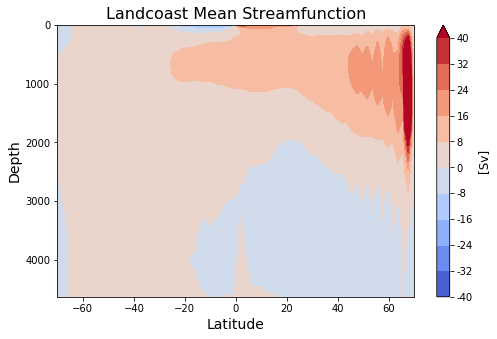

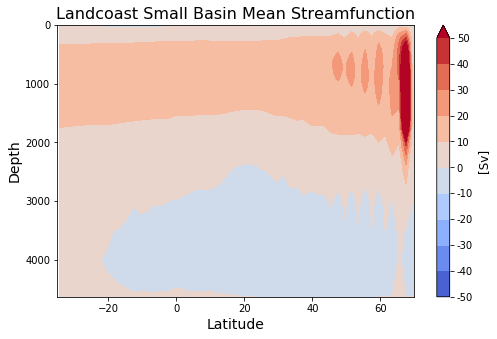

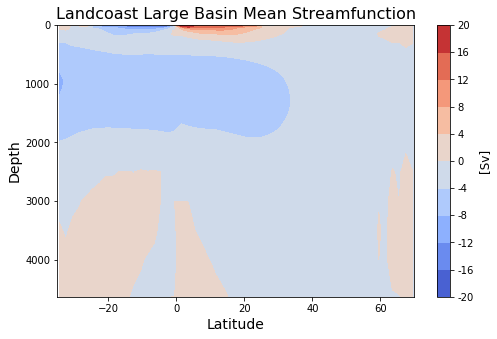

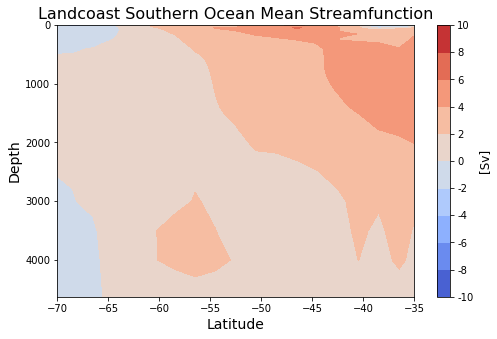

In [31]:
t = np.linspace(-40, 40, 11, endpoint=True)
v = np.linspace(-50, 50, 11, endpoint=True)
c = np.linspace(-20, 20, 11, endpoint=True)
s = np.linspace(-10, 10, 11, endpoint=True)

plt.subplots(figsize=(8,5))
plt.contourf(lat, z, (np.nanmean(sfn[-20:-10,:,:], axis=0))/(1e6), 
             t, cmap='coolwarm', extend='max')
plt.gca().invert_yaxis()
plt.xlim(-70, 70)
cbar = plt.colorbar(ticks=t, format = '%.0f')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Landcoast Mean Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_MeanSfn.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
plt.contourf(lat[22:], z, sfn_small_end/(1e6), v, cmap='coolwarm', extend='max')
plt.gca().invert_yaxis()
plt.xlim(-35, 70)
cbar = plt.colorbar(ticks=v, format = '%.0f')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Landcoast Small Basin Mean Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_MeanSfn_small.pdf', bbox_inches='tight')
plt.show()

plt.subplots(figsize=(8,5))
plt.contourf(lat[22:], z, sfn_large_end/(1e6), c, cmap='coolwarm')
plt.gca().invert_yaxis()
plt.xlim(-35, 70)
cbar = plt.colorbar(ticks=c, format = '%.0f')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Landcoast Large Basin Mean Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_MeanSfn_large.pdf', bbox_inches='tight')
plt.show()

plt.subplots(figsize=(8,5))
plt.contourf(lat[:23], z, sfn_so_end/(1e6), s, cmap='coolwarm')
plt.gca().invert_yaxis()
plt.xlim(-70, -35)
cbar = plt.colorbar(ticks=s, format = '%.0f')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Landcoast Southern Ocean Mean Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_MeanSfn_s0.pdf', bbox_inches='tight')
plt.show()

In [6]:
sfn_res = (vhGM/1025).sum('xh').cumsum('zl')

sfnres_small = np.cumsum(np.nansum((vhGM[:,:,22:,50:100])/1025, axis=3), axis=1)
sfnres_small_end = np.nanmean(sfnres_small[-20:-10,:,:], axis=0)

large_vhGM = np.append(vhGM[:,:,22:,100:], vhGM[:,:,22:,:50], axis=3)
sfnres_large = np.cumsum(np.nansum(large_vhGM/1025, axis=3), axis=1)
sfnres_large_end = np.nanmean(sfnres_large[-20:-10,:,:], axis=0)

sfnres_so = np.cumsum(np.nansum((vhGM[:,:,:23,:])/1025, axis=3), axis=1)
sfnres_so_end = np.nanmean(sfnres_so[-20:-10,:,:], axis=0)

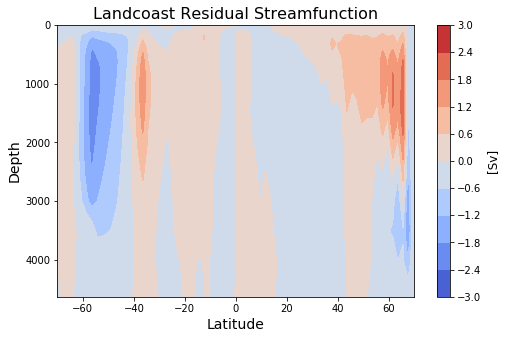

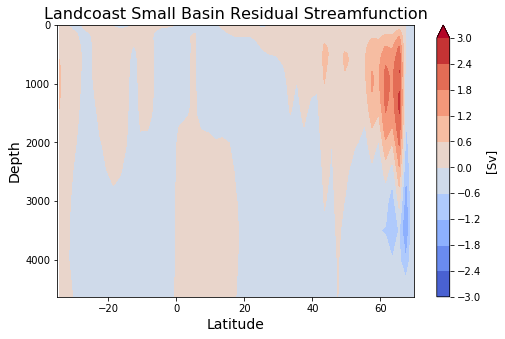

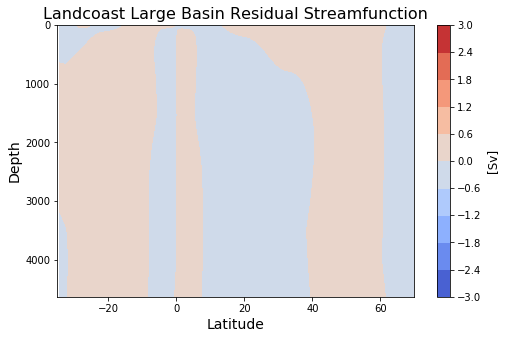

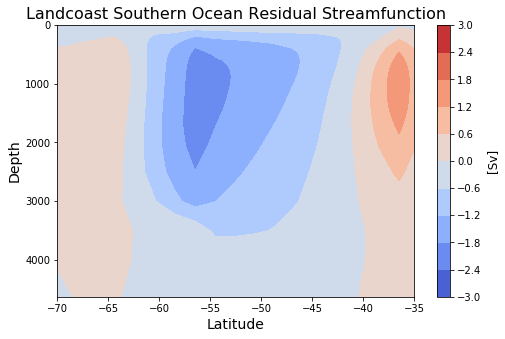

In [10]:
t = np.linspace(-3, 3, 11, endpoint=True)
v = np.linspace(-3, 3, 11, endpoint=True)
c = np.linspace(-3, 3, 11, endpoint=True)
s = np.linspace(-3, 3, 11, endpoint=True)

plt.subplots(figsize=(8,5))
plt.contourf(lat, z, (np.nanmean(sfn_res[-20:-10,:,:], axis=0))/(1e6), 
            t, cmap='coolwarm')
plt.gca().invert_yaxis()
plt.xlim(-70, 70)
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Landcoast Residual Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_ResSfn.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
plt.contourf(lat[22:], z, sfnres_small_end/(1e6), v, cmap='coolwarm', extend='max')
plt.gca().invert_yaxis()
plt.xlim(-35, 70)
cbar = plt.colorbar(ticks=v, boundaries=v, spacing='uniform')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Landcoast Small Basin Residual Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_ResSfn_small.pdf', bbox_inches='tight')
plt.show()

plt.subplots(figsize=(8,5))
plt.contourf(lat[22:], z, sfnres_large_end/(1e6), c, cmap='coolwarm')
plt.gca().invert_yaxis()
plt.xlim(-35, 70)
cbar = plt.colorbar(ticks=c, boundaries=c, spacing='uniform')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Landcoast Large Basin Residual Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_ResSfn_large.pdf', bbox_inches='tight')
plt.show()

plt.subplots(figsize=(8,5))
plt.contourf(lat[:23], z, sfnres_so_end/(1e6), s, cmap='coolwarm')
plt.gca().invert_yaxis()
plt.xlim(-70, -35)
cbar = plt.colorbar(ticks=s, boundaries=s, spacing='uniform')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Landcoast Southern Ocean Residual Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_ResSfn_so.pdf', bbox_inches='tight')
plt.show()

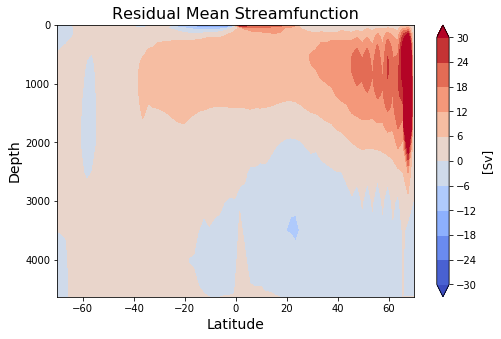

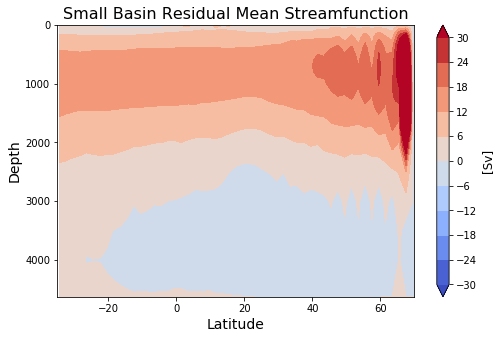

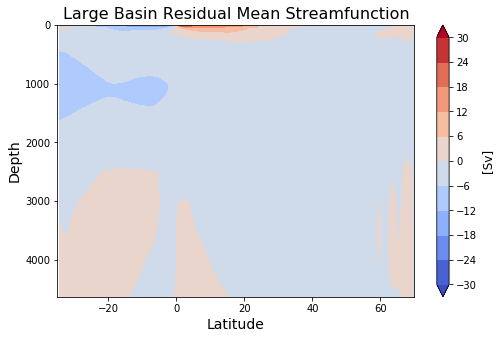

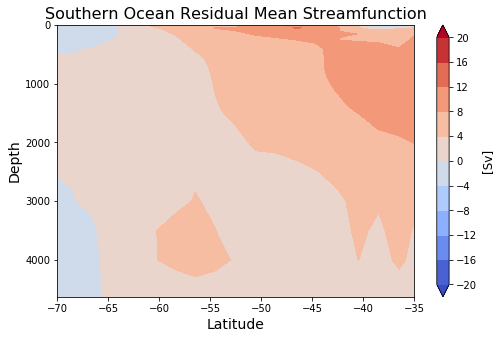

In [8]:
t = np.linspace(-30, 30, 11, endpoint=True)
v = np.linspace(-30, 30, 11, endpoint=True)
c = np.linspace(-30, 30, 11, endpoint=True)
s = np.linspace(-20, 20, 11, endpoint=True)

plt.subplots(figsize=(8,5))
plt.contourf(lat, z, ((np.nanmean(sfn[-20:-10,:,:], axis=0))+(np.nanmean(sfn_res[-20:-10,:,:], axis=0)))/(1e6), 
             t, cmap='coolwarm', extend='both')
plt.gca().invert_yaxis()
plt.xlim(-70, 70)
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Residual Mean Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_ResMeanSfn.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
plt.contourf(lat[22:], z, (sfn_small_end+sfnres_small_end)/(1e6), 
             v, cmap='coolwarm', extend='both')
plt.gca().invert_yaxis()
plt.xlim(-35, 70)
cbar = plt.colorbar(ticks=v, boundaries=v, spacing='uniform')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Small Basin Residual Mean Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_ResMeanSfn_small.pdf', bbox_inches='tight')
plt.show()

plt.subplots(figsize=(8,5))
plt.contourf(lat[22:], z, (sfn_large_end+sfnres_large_end)/(1e6), 
             c, cmap='coolwarm', extend='both')
plt.gca().invert_yaxis()
plt.xlim(-35, 70)
cbar = plt.colorbar(ticks=c, boundaries=c, spacing='uniform')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Large Basin Residual Mean Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_ResMeanSfn_large.pdf', bbox_inches='tight')
plt.show()

plt.subplots(figsize=(8,5))
plt.contourf(lat[:23], z, (sfn_so_end+sfn_so_end)/(1e6), 
             s, cmap='coolwarm',extend='both')
plt.gca().invert_yaxis()
plt.xlim(-70, -35)
cbar = plt.colorbar(ticks=s, boundaries=s, spacing='uniform')
cbar.ax.set_ylabel('[Sv]', fontsize=12)
plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('Southern Ocean Residual Mean Streamfunction', fontsize=16)
plt.savefig('./FIGURES/landcoast_ResMeanSfn_s0.pdf', bbox_inches='tight')
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


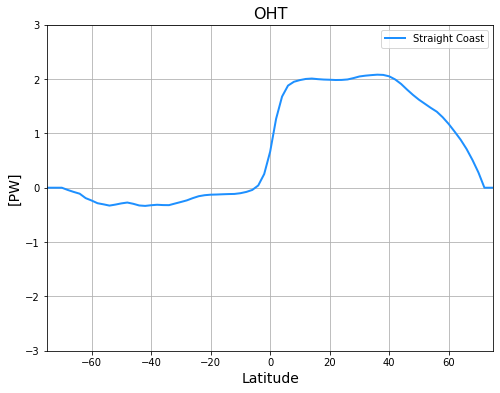

In [5]:
OHT = calculate_OHT(T_ady_2d, T_diffy_2d)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(f['yq']+1, OHT, color='dodgerblue', linewidth=2, label=case)
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-3, 3)
plt.legend()
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
#plt.savefig('path/to/figure', bbox_inches='tight')
plt.show()

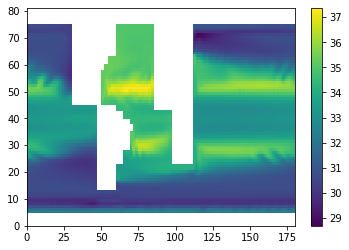

In [6]:
plt.pcolormesh(dy['sos'][-1,:,:])
plt.colorbar()
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


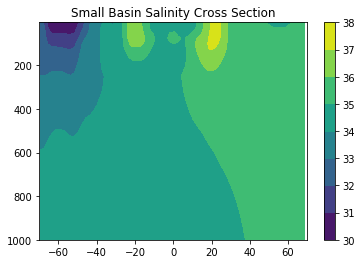

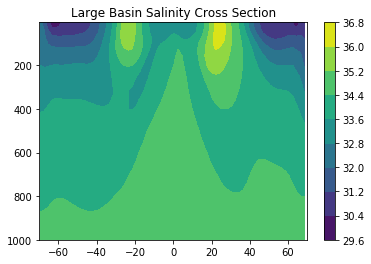

In [10]:
# salinity = dy['so'][:]
salt = np.nanmean(salinity[-361:,:,:,:], axis=0)

ind = np.where(dy['zl'] == 1000)
z = ind[0][0] + 1

# small = 156 
plt.contourf(dy['yh'], dy['zl'][0:z], np.squeeze(salt[:z,:,78]))
plt.gca().invert_yaxis()
plt.xlim([-70,70])
plt.title('Small Basin Salinity Cross Section')
plt.colorbar()
plt.show()

# large = 300
plt.contourf(dy['yh'], dy['zl'][0:z], np.squeeze(salt[:z,:,150]))
plt.gca().invert_yaxis()
plt.xlim([-70,70])
plt.title('Large Basin Salinity Cross Section')
plt.colorbar()
plt.show()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))